# 笔记
## 1 图像卷积

- 互相关运算

在卷积层中，输入张量和核张量通过互相关运算产生输出张量。
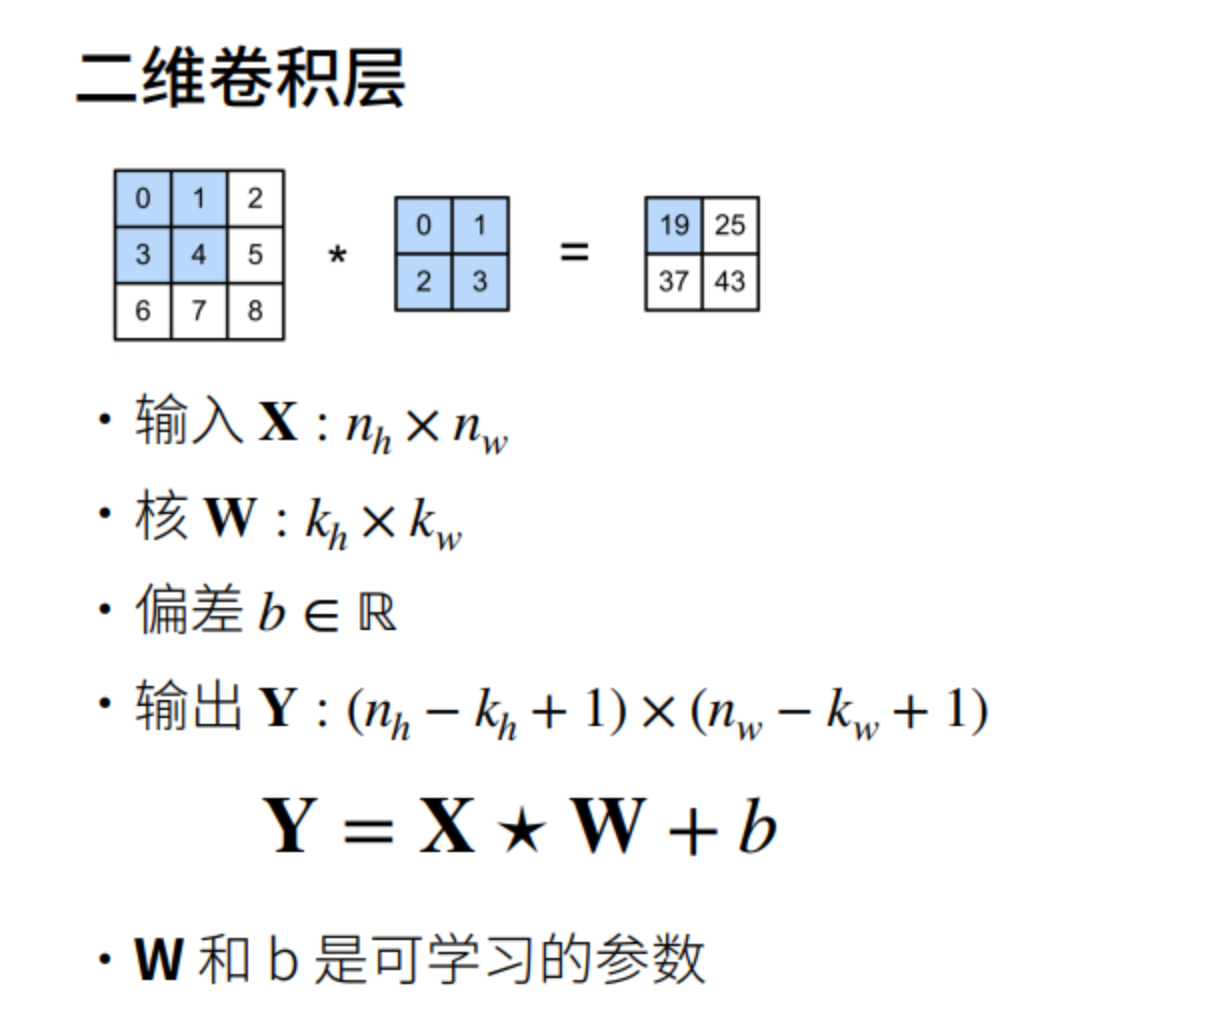

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

#计算二维互相关运算
def corr2d(X,K):
    h,w = K.shape
    # Y：存储互相关运算的结果。形状是根据输入数据 X 和卷积核 K 的尺寸来确定的。
    Y = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h,j:j+w]* K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

- 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。 所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。 

In [3]:
# 在__init__构造函数中，将weight和bias声明为两个模型参数。
# 前向传播函数调用corr2d函数并添加偏置。 
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

- 简单应用：边缘检测

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
print(Y)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [5]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

- 学习卷积核：仅查看“输入-输出”对来学习由X生成Y的卷积核。

1. 使用 PyTorch 的 nn.Conv2d 类创建了一个二维卷积层对象 conv2d。    

In [6]:
conv2d = nn.Conv2d(1,1,kernel_size=(1, 2),bias=False)

<font color=red> 其中参数 1, 1 分别表示输入通道数和输出通道数，这里意味着输入数据只有一个通道（比如单通道的灰度图像或者经过处理后的数据只有一个特征通道），经过卷积操作后也输出一个通道的数据。kernel_size=(1, 2) 则指定了卷积核的大小为高度是 1、宽度是 2 的二维形状。

2. 调整输入输出数据的形状

In [11]:
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
X,Y

(tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
           [1., 1., 0., 0., 0., 0., 1., 1.],
           [1., 1., 0., 0., 0., 0., 1., 1.],
           [1., 1., 0., 0., 0., 0., 1., 1.],
           [1., 1., 0., 0., 0., 0., 1., 1.],
           [1., 1., 0., 0., 0., 0., 1., 1.]]]]),
 tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
           [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
           [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
           [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
           [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
           [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]]))

<font color=red> 使用卷积层时，数据通常按照特定的维度顺序进行组织，即 **(批量大小, 通道, 高度, 宽度)** 的四维格式。

3. 设置学习率并开始训练循环

In [8]:
lr = 3e-2  # 学习率
for i in range(10): # 10次迭代
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2 
    conv2d.zero_grad() #每次进行反向传播计算梯度之前 将之前累积的梯度清零
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad # 迭代卷积核
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 6.069
epoch 4, loss 1.042
epoch 6, loss 0.184
epoch 8, loss 0.035
epoch 10, loss 0.007


In [9]:
# 现在我们来看看我们所学的卷积核的权重张量。
conv2d.weight.data

tensor([[[[ 0.9819, -0.9927]]]])

💡补充：切片是对原列表进行操作

In [35]:
my_list = [1, 2, 3, 4, 5]
my_list[:2] = [-1 , -1]
my_list

[-1, -1, 3, 4, 5]

## 2. 填充和步幅
填充和步幅是卷积层的超参数 
- 填充在输入周围添加额外的行/列，来控制输出形状的減少量 
- 步幅是每次滑动核窗口时的行/列的步长，可以成倍的减少输出形状



1. 填充
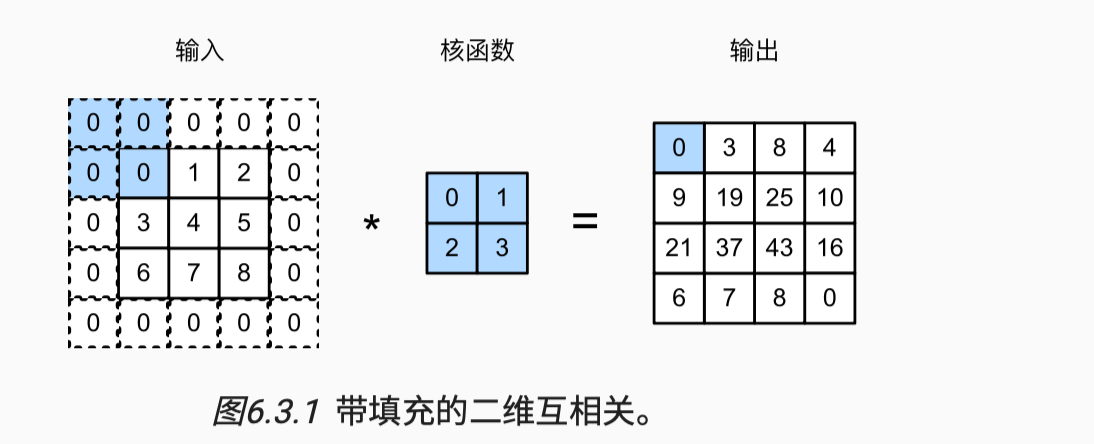

In [ ]:
conv2d = nn.Conv2d(1,1,kernel_zise=3,padding=1)

2. 步幅
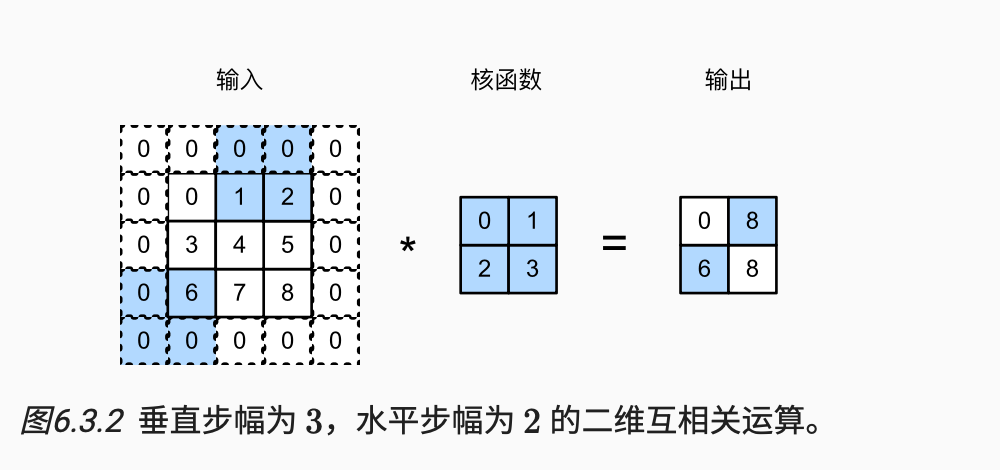
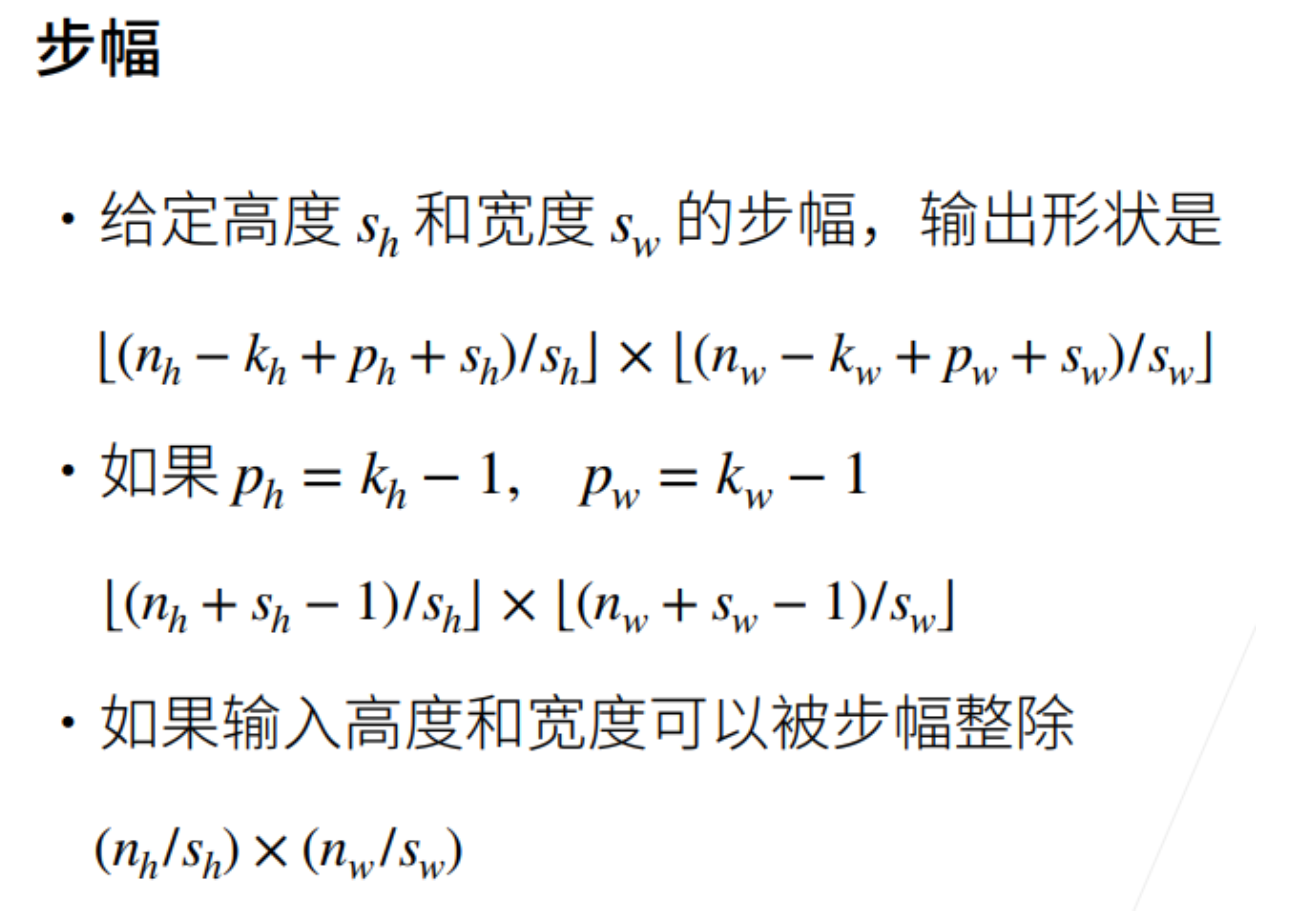

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)

In [13]:
# 总的来说

# 在所有侧边填充1个像素
import torch
from torch import nn

def comp_conv2d(conv2d, X): # conv2d 作为传参传进去，在内部使用
    X = X.reshape((1,1)+X.shape) # 在维度前面加入一个通道数和批量大小数
    Y = conv2d(X)  # 卷积处理是一个四维的矩阵
    return Y.reshape(Y.shape[2:]) # 将前面两个维度拿掉

conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1) # padding=1 为左右都填充一行
X = torch.rand(size=(8,8))
print(comp_conv2d(conv2d,X).shape)
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
print(comp_conv2d(conv2d,X).shape)

# 将高度和宽度的步幅设置为2
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
print(comp_conv2d(conv2d,X).shape)

# 一个稍微复杂的例子
conv2d = nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
print(comp_conv2d(conv2d,X).shape)

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([4, 4])
torch.Size([2, 2])


Q：步幅大于1的计算优势是什么？

W: 可以很快的提取图片的大致特征，快速的降低输出的维数

## 3. 多输入多输出通道

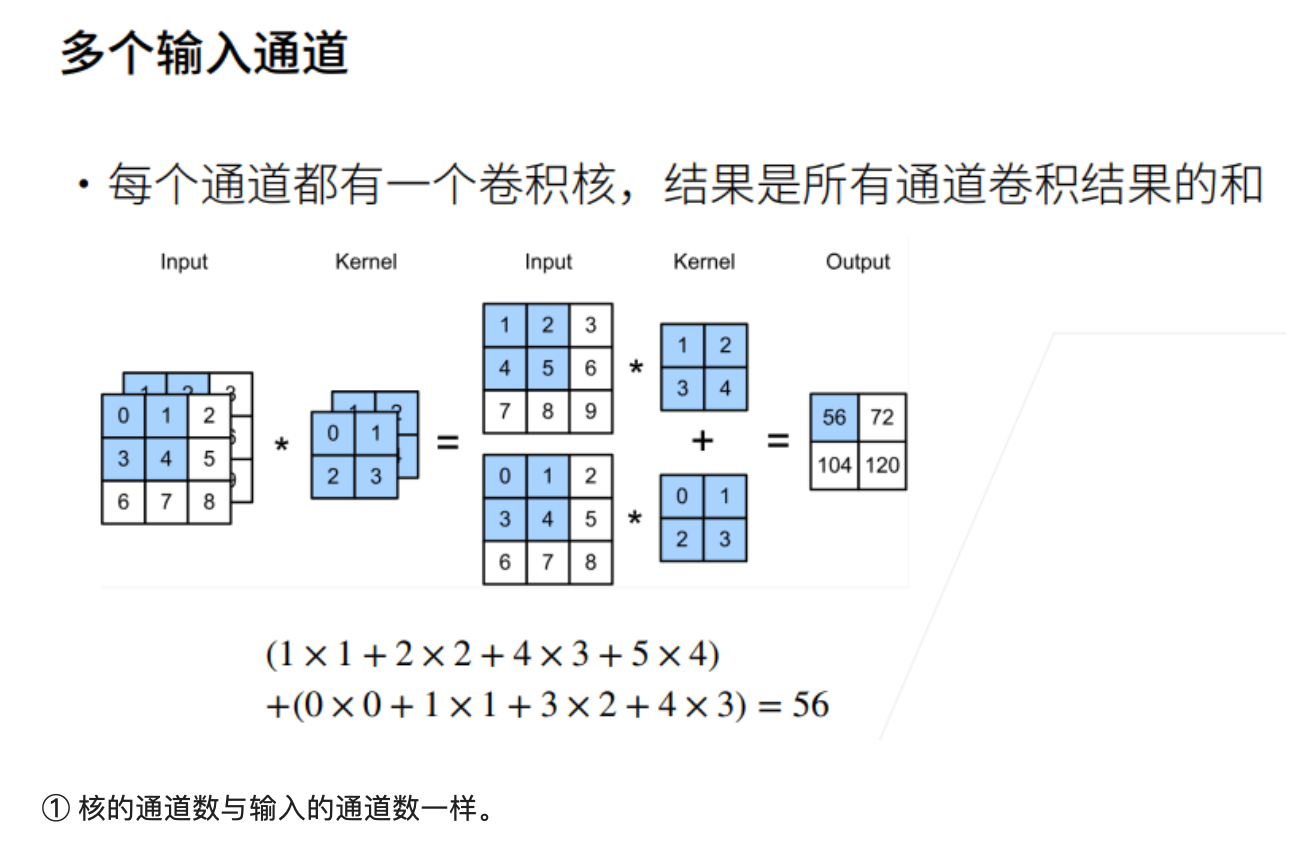
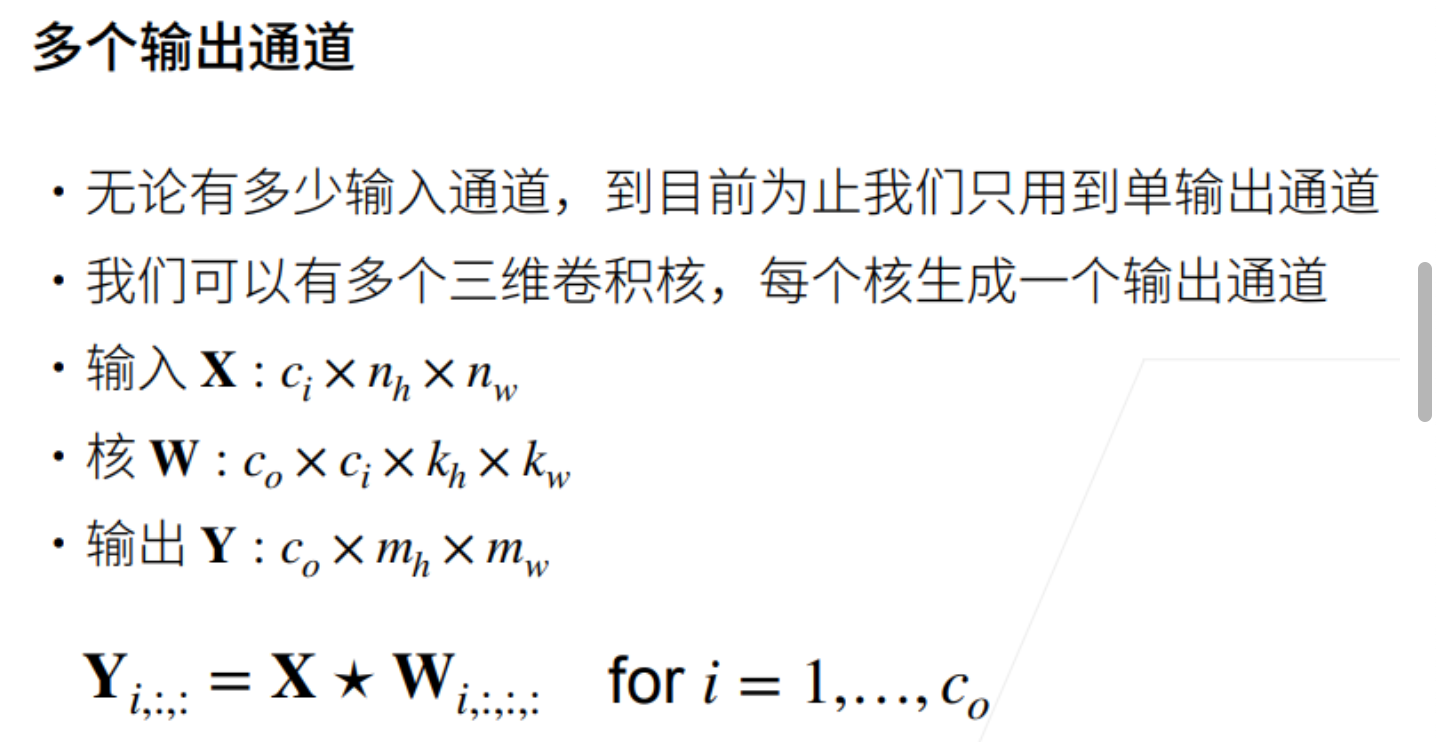

- 为什么需要多个输出通道：每个输出通道可以匹配图片里面特定的模式。
- 输入通道就是上一层的输出通道，然后又通过kernel将这些通道组合起来。下层的kernel可能捕捉局部信息，越往上就越将这些特征组合起来。
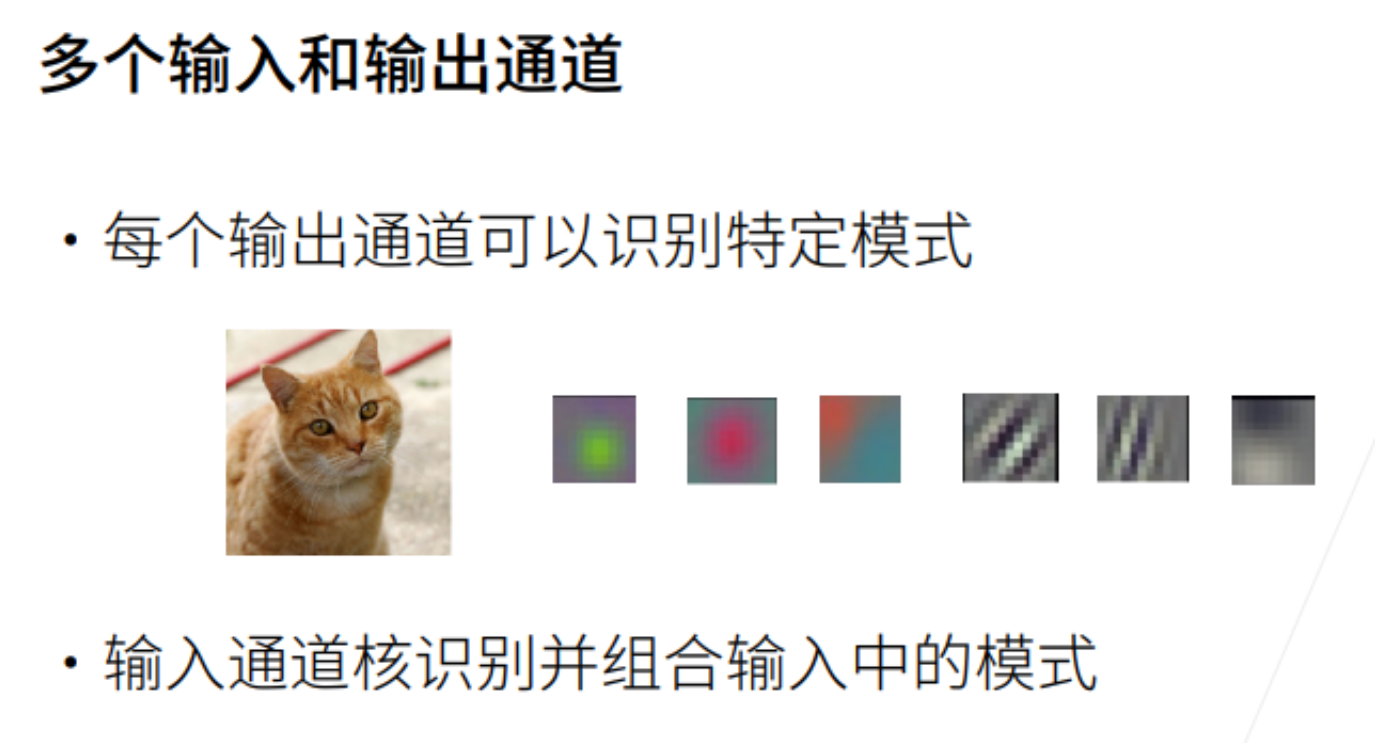

1 \* 1 卷积：因为使用了最小窗口，卷积失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。 其实卷积的唯一计算发生在通道上。
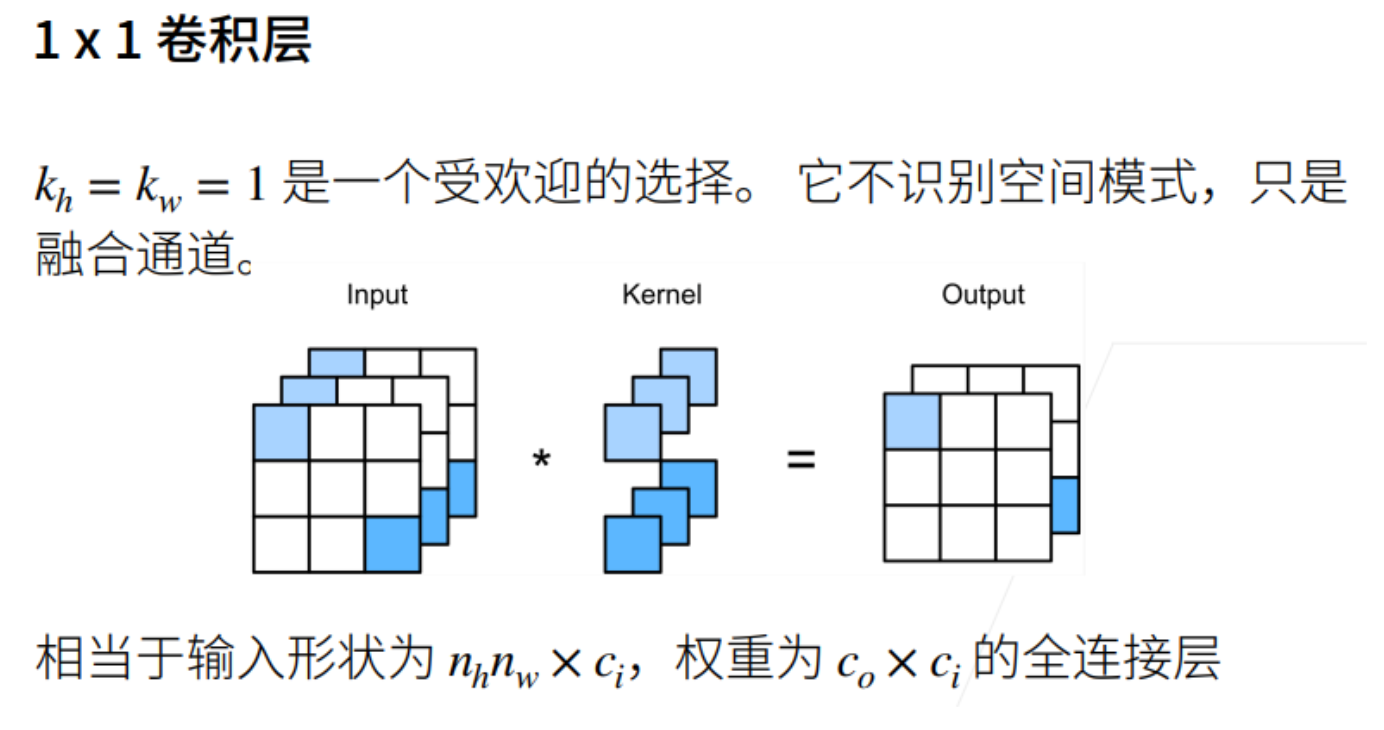

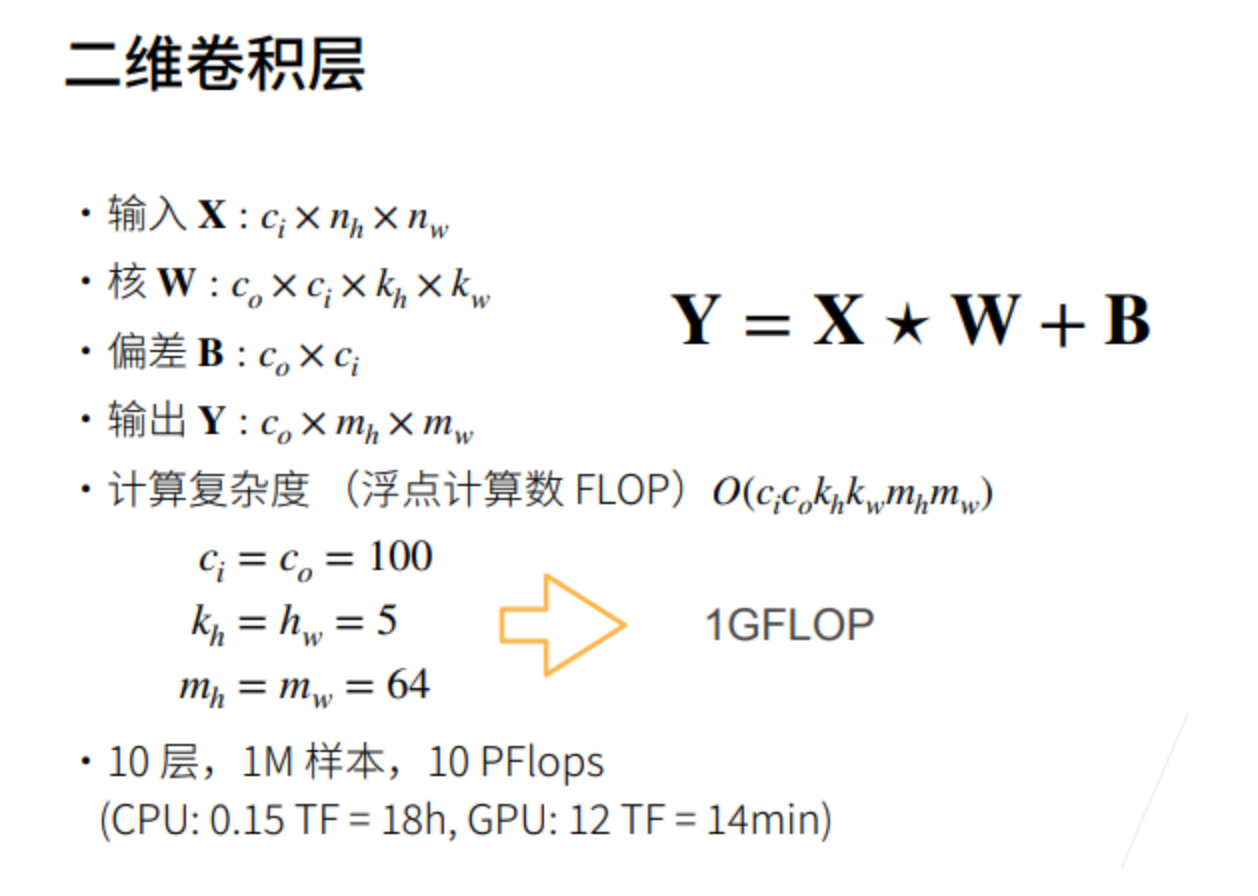

 小结

- 多输入多输出通道可以用来扩展卷积层的模型。
- 当以每像素为基础应用时，1✖️1卷积层相当于全连接层。
- 1✖️1卷积层通常用于调整网络层的通道数量和控制模型复杂性。

## 4. pooling

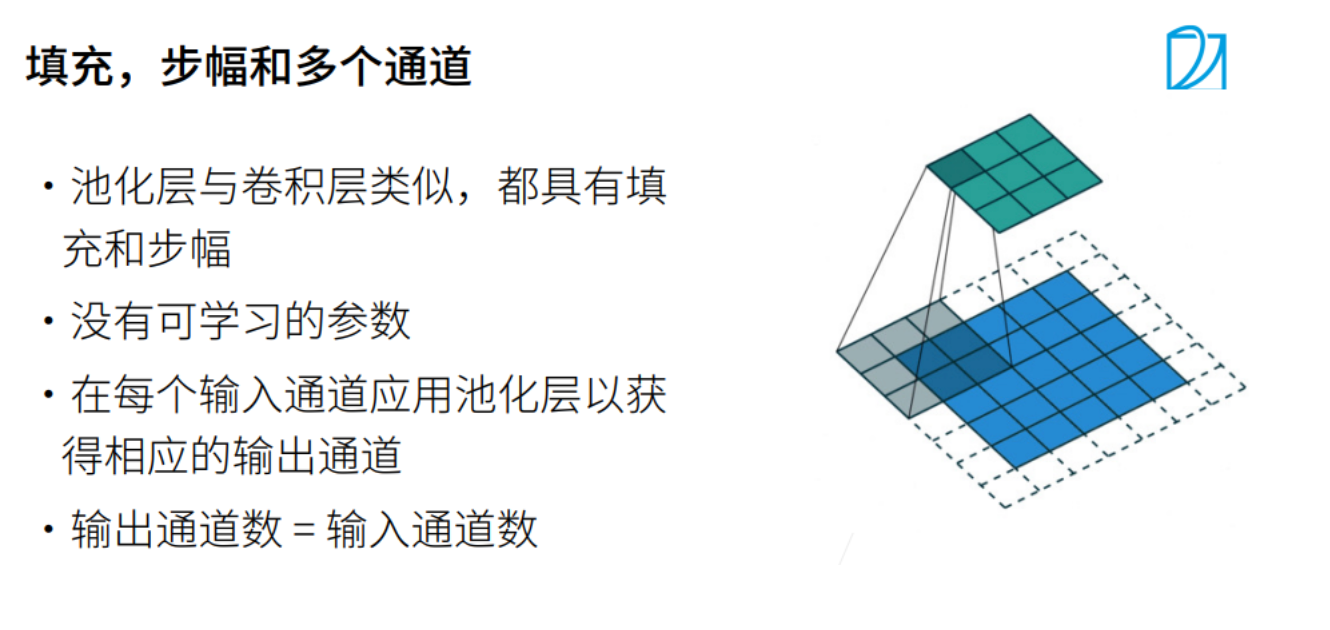

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X,pool_size,mode='max'):
    p_h,p_w = pool_size
    Y = torch.zeros(X.shape[0]-p_h+1,X.shape[1]-p_w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == 'avg':
                Y[i,j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [17]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

- 使用深度学习框架

In [26]:
# 先构造输入张量
X = torch.arange(16,dtype=torch.float32).reshape(1,1,4,4)
print(X)
# 深度学习框架中的步幅与汇聚窗口的大小相同
pool2d = nn.MaxPool2d(3)
print(pool2d(X))
# 填充和步幅可以手动设定 
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
print(pool2d(X))

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[10.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


有多个通道时，输出通道等于输入通道。（我们先用cat把创造两个通道的数据）

在处理多通道输入数据时，汇聚层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。 这意味着汇聚层的输出通道数与输入通道数相同。

In [27]:
# torch.cat() 函数用于将多个张量按照指定的维度拼接在一起，基本语法是 torch.cat(tensors, dim)
X = torch.cat((X,X+1),1)
print(X.shape,X)
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

torch.Size([1, 2, 4, 4]) tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])


tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [35]:
# 第二个例子说明对输入张量 X 的每个通道独立进行操作，不会在通道之间进行数据混合
X = torch.arange(72,dtype=torch.float32).reshape(2,1,6,6)
print(X.shape)
# 深度学习框架中的步幅与汇聚窗口的大小相同
pool2d = nn.MaxPool2d(3)
print(pool2d(X).shape)

torch.Size([2, 1, 6, 6])
torch.Size([2, 1, 2, 2])


总结
- <font color=red>汇聚层的主要优点之一是减轻卷积层对位置的过度敏感。</font>
    - 卷积层输出的特征图对输入数据中特征的位置是比较敏感的。因为卷积核在输入图像上滑动进行卷积操作时，每个像素的位置信息在特征图中是有明确体现的。
而汇聚层通过在局部区域内进行汇总操作，例如最大汇聚只关心局部区域内的最大值，这样就减少了特征图的尺寸，同时也使得网络对于特征位置的微小变化不那么敏感
- 我们可以指定汇聚层的填充和步幅。
- 使用最大汇聚层以及大于1的步幅，可减少空间维度（如高度和宽度）。
- 汇聚层的输出通道数与输入通道数相同。
-  <font color=red>没有可以学习的参数，但是有窗口大小、填充、和步幅作为超参数